# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import urllib.request
import gzip
import os

# Dataset

In [2]:
# ============================================================================
# DATASET LOADING FROM URL (Direct Download)
# ============================================================================
def download_fashion_mnist():
    """Download Fashion-MNIST directly from URLs"""
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }

    data_dir = './fashion_mnist_data'
    os.makedirs(data_dir, exist_ok=True)

    downloaded = {}
    for key, filename in files.items():
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(base_url + filename, filepath)
        downloaded[key] = filepath

    return downloaded

def load_mnist_images(filepath):
    """Load MNIST-format images from gzipped file"""
    with gzip.open(filepath, 'rb') as f:
        # Read header: magic number, num images, rows, cols
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # Reshape to (num_images, 28, 28, 1)
    return data.reshape(-1, 28, 28, 1)

def load_mnist_labels(filepath):
    """Load MNIST-format labels from gzipped file"""
    with gzip.open(filepath, 'rb') as f:
        # Read header: magic number, num labels
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

print("Loading Fashion-MNIST from URL...")
files = download_fashion_mnist()

train_images = load_mnist_images(files['train_images'])
train_labels = load_mnist_labels(files['train_labels'])
test_images = load_mnist_images(files['test_images'])
test_labels = load_mnist_labels(files['test_labels'])

print(f"Train: {train_images.shape}, Test: {test_images.shape}")

Loading Fashion-MNIST from URL...
Train: (60000, 28, 28, 1), Test: (10000, 28, 28, 1)


# Data Normalization

In [3]:
# ============================================================================
# DATA PIPELINE
# ============================================================================
BATCH = 60
AUTO = tf.data.AUTOTUNE

# Normalize to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Split: 50k train, 10k validation
val_images = train_images[50000:]
val_labels = train_labels[50000:]
train_images = train_images[:50000]
train_labels = train_labels[:50000]

# Create TF datasets
train_ds_real = tf.data.Dataset.from_tensor_slices((train_images, tf.cast(train_labels, tf.int32)))
train_ds_real = train_ds_real.shuffle(50000).batch(BATCH).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.batch(BATCH).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH).prefetch(AUTO)

# GAN dataset (images only, scaled to [-1, 1] for tanh)
gan_images = (train_images * 2.0) - 1.0  # [0,1] -> [-1,1]
gan_ds = tf.data.Dataset.from_tensor_slices(gan_images)
gan_ds = gan_ds.shuffle(50000).batch(BATCH).prefetch(AUTO)

class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# GAN Arch

In [4]:
# ============================================================================
# GAN ARCHITECTURE
# ============================================================================
NOISE_DIM = 100
GEN_LR = 2e-4
DISC_LR = 2e-4
EPOCHS_GAN = 50
LABEL_SMOOTHING = 0.1

def build_generator():
    model = models.Sequential(name='Generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(1, 5, padding='same', activation='tanh'))
    return model

def build_discriminator():
    model = models.Sequential(name='Discriminator')
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

generator = build_generator()
discriminator = build_discriminator()

g_opt = tf.keras.optimizers.Adam(GEN_LR, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(DISC_LR, beta_1=0.5)

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                         label_smoothing=LABEL_SMOOTHING)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# GAN Training


TRAINING GAN
Epoch 001/50  D_loss=1.3569  G_loss=0.7134
Epoch 002/50  D_loss=1.3161  G_loss=0.7544
Epoch 003/50  D_loss=1.3493  G_loss=0.7361
Epoch 004/50  D_loss=1.3541  G_loss=0.7324
Epoch 005/50  D_loss=1.3547  G_loss=0.7335
Epoch 006/50  D_loss=1.3535  G_loss=0.7346
Epoch 007/50  D_loss=1.3563  G_loss=0.7322
Epoch 008/50  D_loss=1.3571  G_loss=0.7329
Epoch 009/50  D_loss=1.3561  G_loss=0.7337
Epoch 010/50  D_loss=1.3560  G_loss=0.7360
Epoch 011/50  D_loss=1.3562  G_loss=0.7358
Epoch 012/50  D_loss=1.3561  G_loss=0.7359
Epoch 013/50  D_loss=1.3566  G_loss=0.7353
Epoch 014/50  D_loss=1.3572  G_loss=0.7366
Epoch 015/50  D_loss=1.3577  G_loss=0.7358
Epoch 016/50  D_loss=1.3551  G_loss=0.7377
Epoch 017/50  D_loss=1.3572  G_loss=0.7371
Epoch 018/50  D_loss=1.3564  G_loss=0.7366
Epoch 019/50  D_loss=1.3553  G_loss=0.7389
Epoch 020/50  D_loss=1.3583  G_loss=0.7370
Epoch 021/50  D_loss=1.3584  G_loss=0.7367
Epoch 022/50  D_loss=1.3567  G_loss=0.7377
Epoch 023/50  D_loss=1.3571  G_loss=0.73

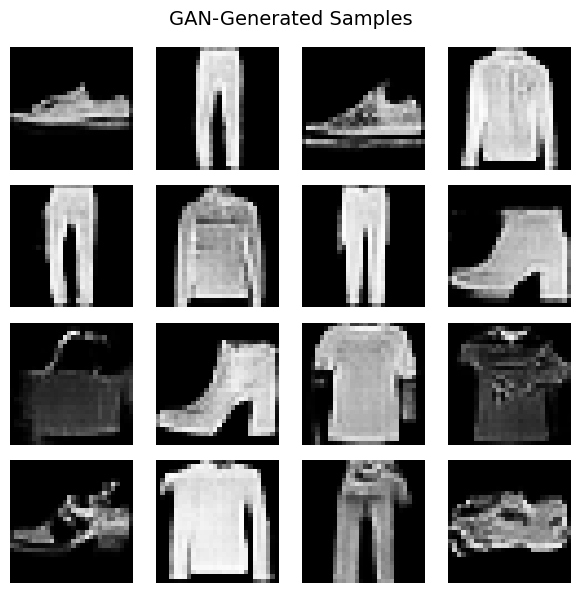

In [5]:
# ============================================================================
# GAN TRAINING
# ============================================================================
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_imgs = generator(noise, training=True)

        real_logits = discriminator(images, training=True)
        fake_logits = discriminator(fake_imgs, training=True)

        d_loss_real = bce(tf.ones_like(real_logits), real_logits)
        d_loss_fake = bce(tf.zeros_like(fake_logits), fake_logits)
        d_loss = d_loss_real + d_loss_fake

        g_loss = bce(tf.ones_like(fake_logits), fake_logits)

    grads_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grads_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    g_opt.apply_gradients(zip(grads_g, generator.trainable_variables))
    d_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return {'d_loss': d_loss, 'g_loss': g_loss}

print("\n" + "="*60)
print("TRAINING GAN")
print("="*60)

for epoch in range(1, EPOCHS_GAN+1):
    losses = {'d_loss': [], 'g_loss': []}
    for img_batch in gan_ds:
        l = train_step(img_batch)
        losses['d_loss'].append(l['d_loss'])
        losses['g_loss'].append(l['g_loss'])

    d_mean = np.mean(losses['d_loss'])
    g_mean = np.mean(losses['g_loss'])
    print(f"Epoch {epoch:03d}/{EPOCHS_GAN}  D_loss={d_mean:.4f}  G_loss={g_mean:.4f}")

    # Check for convergence issues
    if d_mean < 0.01 and epoch > 10:
        print(" Discriminator too strong, stopping early")
        break
    if g_mean > 5.0 and epoch > 10:
        print(" Generator struggling, stopping early")
        break

# Visualize generated samples
noise = tf.random.normal([16, NOISE_DIM])
fake = generator(noise, training=False)
fake = (fake + 1.0) / 2.0  # [-1,1] -> [0,1]

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake[i, :, :, 0], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle("GAN-Generated Samples", fontsize=14)
plt.tight_layout()
plt.show()

# Genrating synthetic data

In [6]:
# ============================================================================
# GENERATE SYNTHETIC DATASET WITH RANDOM LABELS
# ============================================================================
print("\n" + "="*60)
print("GENERATING SYNTHETIC DATA")
print("="*60)

SYNTH_SIZE = 30000

def generate_synthetic_batch(batch_size):
    """Generate a batch of synthetic images with random labels"""
    noise = tf.random.normal([batch_size, NOISE_DIM])
    fake_images = generator(noise, training=False)
    fake_images = (fake_images + 1.0) / 2.0  # [-1,1] -> [0,1]
    # Assign random labels (uniformly distributed across 10 classes)
    fake_labels = tf.random.uniform([batch_size], 0, 10, dtype=tf.int32)
    return fake_images, fake_labels

# Generate synthetic dataset in batches to avoid memory issues
synth_ds = tf.data.Dataset.range(SYNTH_SIZE // BATCH).map(
    lambda _: generate_synthetic_batch(BATCH),
    num_parallel_calls=AUTO
).unbatch().shuffle(SYNTH_SIZE).batch(BATCH).prefetch(AUTO)

print(f" Generated {SYNTH_SIZE} synthetic samples")



GENERATING SYNTHETIC DATA
 Generated 30000 synthetic samples


# Mixing both Data (Genrated + Original)

In [7]:
# ============================================================================
# CREATE MIXED DATASET (70% real, 30% synthetic)
# ============================================================================
# Calculate steps for balanced mixing
real_samples = 50000
synth_samples = SYNTH_SIZE
total_ratio = 0.7 + 0.3
steps_per_epoch = int((real_samples * 0.7 / total_ratio) / BATCH)

mixed_ds = tf.data.Dataset.sample_from_datasets(
    [train_ds_real.repeat(), synth_ds.repeat()],
    weights=[0.7, 0.3],
    stop_on_empty_dataset=False
).take(steps_per_epoch * 2).prefetch(AUTO)  # 2 epochs worth

print(f" Mixed dataset: 70% real, 30% synthetic (~{steps_per_epoch} steps/epoch)")


 Mixed dataset: 70% real, 30% synthetic (~583 steps/epoch)


# ResNet Arch

In [8]:
# ============================================================================
# RESNET20 CLASSIFIER
# ============================================================================
def res_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def ResNet20():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, 3, padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(3): x = res_block(x, 16)
    x = res_block(x, 32, stride=2)
    for _ in range(2): x = res_block(x, 32)
    x = res_block(x, 64, stride=2)
    for _ in range(2): x = res_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10)(x)
    return models.Model(inputs, outputs)

classifier = ResNet20()
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


# Train Resnet

In [9]:
# ============================================================================
# TRAIN CLASSIFIER
# ============================================================================
print("\n" + "="*60)
print("TRAINING CLASSIFIER ON MIXED DATASET")
print("="*60)

EPOCHS_C = 40
callbacks_list = [
    callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                               patience=3, verbose=1, min_lr=1e-6),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=8,
                           restore_best_weights=True, verbose=1)
]

history = classifier.fit(
    mixed_ds,
    epochs=EPOCHS_C,
    validation_data=val_ds,
    callbacks=callbacks_list,
    verbose=2
)


TRAINING CLASSIFIER ON MIXED DATASET
Epoch 1/40
1166/1166 - 144s - 123ms/step - accuracy: 0.5597 - loss: 1.5901 - val_accuracy: 0.8095 - val_loss: 0.8131 - learning_rate: 1.0000e-03
Epoch 2/40
1166/1166 - 121s - 104ms/step - accuracy: 0.6291 - loss: 1.1096 - val_accuracy: 0.2797 - val_loss: 3.3013 - learning_rate: 1.0000e-03
Epoch 3/40
1166/1166 - 123s - 106ms/step - accuracy: 0.6412 - loss: 1.0397 - val_accuracy: 0.8422 - val_loss: 1.0546 - learning_rate: 1.0000e-03
Epoch 4/40
1166/1166 - 121s - 104ms/step - accuracy: 0.6526 - loss: 0.9991 - val_accuracy: 0.8781 - val_loss: 1.1217 - learning_rate: 1.0000e-03
Epoch 5/40
1166/1166 - 121s - 104ms/step - accuracy: 0.6548 - loss: 1.0014 - val_accuracy: 0.8685 - val_loss: 0.9892 - learning_rate: 1.0000e-03
Epoch 6/40
1166/1166 - 122s - 105ms/step - accuracy: 0.6567 - loss: 0.9800 - val_accuracy: 0.8749 - val_loss: 1.1945 - learning_rate: 1.0000e-03
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1166

# Evaluation


FINAL EVALUATION
 Test Accuracy: 91.40%
 Test Loss: 1.1391

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     T-shirt     0.8169    0.9010    0.8569      1000
     Trouser     0.9909    0.9780    0.9844      1000
    Pullover     0.8481    0.9100    0.8780      1000
       Dress     0.8846    0.9430    0.9129      1000
        Coat     0.9196    0.7890    0.8493      1000
      Sandal     0.9889    0.9810    0.9849      1000
       Shirt     0.7848    0.7220    0.7521      1000
     Sneaker     0.9634    0.9740    0.9687      1000
         Bag     0.9752    0.9830    0.9791      1000
  Ankle boot     0.9766    0.9590    0.9677      1000

    accuracy                         0.9140     10000
   macro avg     0.9149    0.9140    0.9134     10000
weighted avg     0.9149    0.9140    0.9134     10000



<Figure size 1000x800 with 0 Axes>

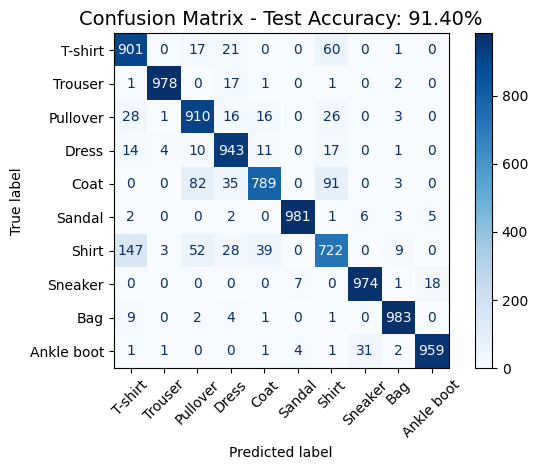


TRAINING COMPLETE!


In [11]:
# ============================================================================
# EVALUATION
# ============================================================================
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

test_loss, test_acc = classifier.evaluate(test_ds, verbose=0)
print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# Collect predictions
y_true_list = []
y_pred_list = []

for images, labels in test_ds:
    y_true_list.append(labels.numpy())
    predictions = classifier.predict(images, verbose=0)
    y_pred_list.append(np.argmax(predictions, axis=1))

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Classification Report
from sklearn.metrics import classification_report

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title(f"Confusion Matrix - Test Accuracy: {test_acc*100:.2f}%", fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)